In [30]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Załadowanie danych

In [2]:
train_x = pd.read_csv('https://raw.githubusercontent.com/mini-pw/2021L-WUM/main/Prace_domowe/Praca_domowa7/train.csv')
train_y = np.array([0]*len(train_x))
test = pd.read_csv('https://raw.githubusercontent.com/mini-pw/2021L-WUM/main/Prace_domowe/Praca_domowa7/test.csv')
test_x = test[test.columns[1:]]
test_y = test[test.columns[0]]
val = pd.read_csv('https://raw.githubusercontent.com/mini-pw/2021L-WUM/main/Prace_domowe/Praca_domowa7/val.csv')

# Model

In [3]:
# Helper functions to display a grid of plots
plotGrid_length = 0
plotGrid_height = 0
plotGrid_count = 0
def initPlotGrid(rowLength, totalPlots, showTicks = False):
    global plotGrid_length, plotGrid_count, plotGrid_height
    plotGrid_length = rowLength
    plotGrid_height = (totalPlots // rowLength) + 1 if totalPlots % rowLength > 0 else totalPlots // rowLength
    plotGrid_count = 0
    
    plt.rcParams['figure.figsize'] = [13, 13/plotGrid_length*plotGrid_height*0.8]
    if(not showTicks):
        plt.rcParams['axes.grid'] = False
        plt.rcParams['xtick.labelsize'] = False
        plt.rcParams['ytick.labelsize'] = False
        plt.rcParams['xtick.top'] = False
        plt.rcParams['xtick.bottom'] = False
        plt.rcParams['ytick.left'] = False
        plt.rcParams['ytick.right'] = False
    
def addToGrid():
    global plotGrid_length, plotGrid_count
    plt.subplot(plotGrid_height, plotGrid_length, plotGrid_count+1)
    plotGrid_count += 1
    
def finalizePlotGrid():
    plt.show()
    plt.style.use('default')

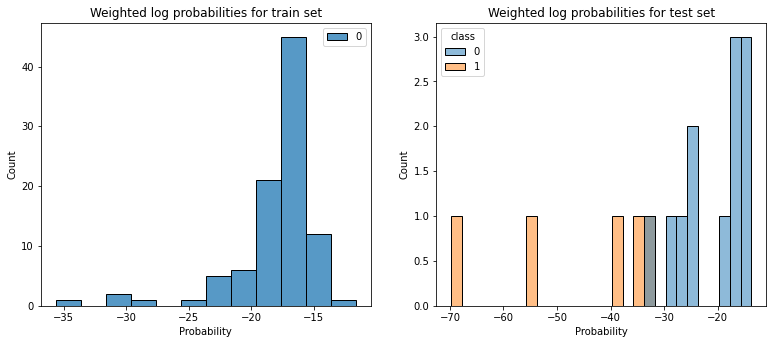

,Max outlier,Min non-outlier
train set,---,-35.632146
test set,-32.747878,-33.084709


In [5]:
gmm = GaussianMixture()
gmm.fit(train_x)
resultData = pd.DataFrame(columns = ["Max outlier", "Min non-outlier"])

def analyzeProbability(title, data, isOutlier):
    score = gmm.score_samples(data)
    resultData.loc[title] = [
        (np.max(score[isOutlier==1]) if any(isOutlier==1) else "---"), 
        (np.min(score[isOutlier==0]) if any(isOutlier==0) else "---")
    ]
    addToGrid()
    ax = sns.histplot(x=score,binwidth=2,hue=isOutlier)
    ax.set_title('Weighted log probabilities for '+title)
    ax.set_xlabel('Probability');

initPlotGrid(2, 1, True)
analyzeProbability("train set",train_x,train_y)
analyzeProbability("test set",test_x,test_y)
finalizePlotGrid()
resultData

Od razu można zauważyć że nie ma prostej granicy dzielącej zbiór outlierów, są wpisy nie bedące outlierami o niższym prawdopodobieństwie niż te, które sa outlierami. 

Przyjmiemy zatem dwie możliwe granice - pierwszą bazującą tylko i wyłącznie na na zbiorze treningowym, wynoszącą `-36`, i drugą bazującą też na zbiorze testowym, wynoszącą `-32`.

# Ewaluacja modeli

In [21]:
results = pd.DataFrame({'F1 score (test)': [], 'Precision (test)': [], 'Recall (test)': [], 'F1 score (train+test)': [], 'Precision (train+test)': [], 'Recall (train+test)': []})

def evaluateResult(treshold):
    pred_y = gmm.score_samples(test_x) < treshold
    
    f1_t = f1_score(test_y,pred_y)
    prec_t = precision_score(test_y,pred_y)
    rec_t = recall_score(test_y,pred_y)
    
    
    all_x = pd.concat([train_x, test_x])
    all_y = np.concatenate((train_y, test_y), axis=0)
    pred_y = gmm.score_samples(all_x) < treshold
    
    f1 = f1_score(all_y,pred_y)
    prec = precision_score(all_y,pred_y)
    rec = recall_score(all_y,pred_y)
    
    
    results.loc["Treshold "+str(treshold)] = [f1_t, prec_t, rec_t, f1, prec, rec]
    
evaluateResult(-36)
evaluateResult(-32)
results

,F1 score (test),Precision (test),Recall (test),F1 score (train+test),Precision (train+test),Recall (train+test)
Treshold -36,0.750000,1.000000,0.6,0.750000,1.000000,0.6
Treshold -32,0.909091,0.833333,1.0,0.833333,0.714286,1.0


Jako że jedna z granic została zbudowana na podstawie samego zbioru testowego, postanowiłem zbadać także miary dla połączenia zbioru testowego i treningowego.

Porównując miary dla obu wybranych granic, od razu widoczne jest że `-32` działa zdecydowanie lepiej dla zbioru testowego. Dla połączonego zbioru sugerując się F1 score można także zauważyć przewagę tej granicy. Największa różnica widoczna jest jednak w precision i recall, dlatego to, który model nadaje się lepiej może zależeć od konsekwencji FP i FN.

# Wizualizacja zbioru walidacyjnego

Jako dodatkowe porównanie modeli może nam służyć dostępny zbiór walidacyjny. Nie zawiera on jednak podpisów klas, więc wnioski będziemy wyciągać na podstawie wizualizacji elementów oznaczonych jako odstające na wykresach T-SNE i PCA.

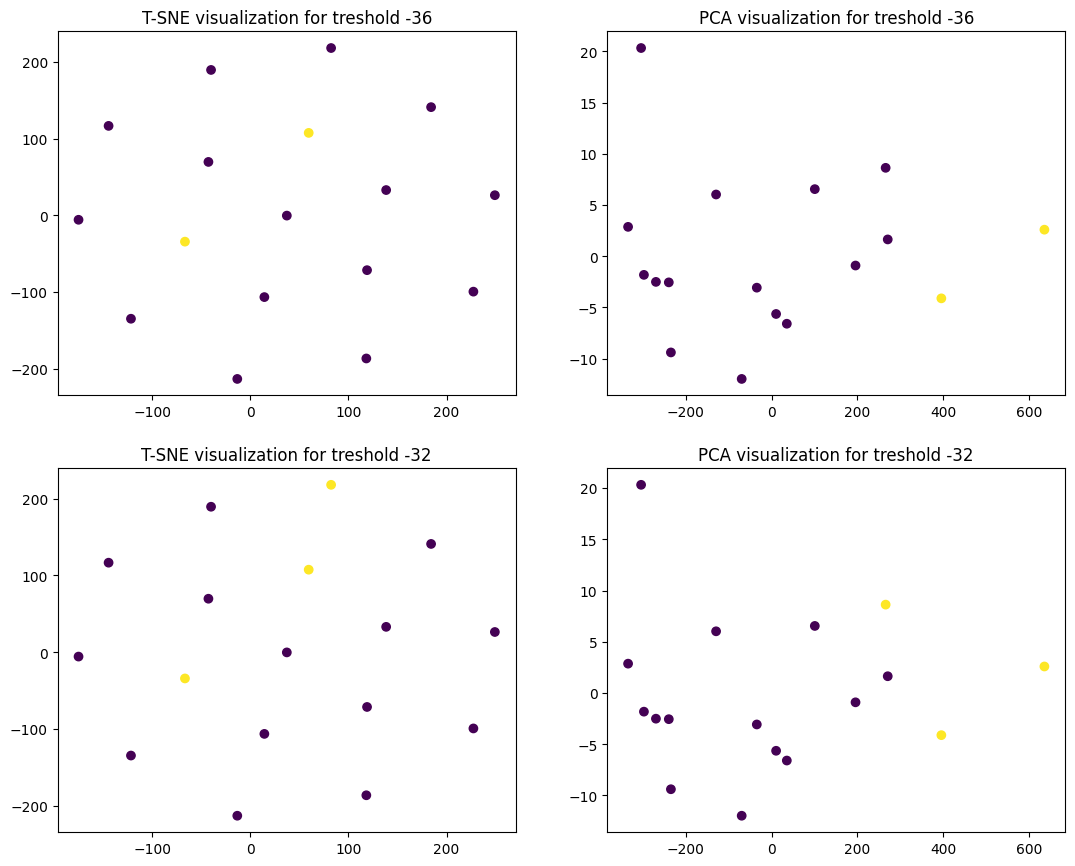

In [31]:
pca = PCA(n_components=2).fit_transform(val)
tsnedata = TSNE().fit_transform(val)

def visualizeResult(treshold):
    pred_y = gmm.score_samples(val) < treshold
    
    addToGrid()
    plt.scatter(tsnedata[:,0], tsnedata[:,1], c=pred_y)
    plt.title('T-SNE visualization for treshold '+str(treshold))
    
    addToGrid()
    plt.scatter(pca[:,0], pca[:,1], c=pred_y)
    plt.title('PCA visualization for treshold '+str(treshold))

initPlotGrid(2, 4, True)
visualizeResult(-36)
visualizeResult(-32)
finalizePlotGrid()

W tym wypadku wizualizacja T-SNE okazuje się zupełnie nieprzydatna. Wykresy PCA także nie pokazują znaczącej różnicy między modelami (głównie z powodu małego zbioru), jednak sugerują minimalną przewagę dla granicy `-36`.

Jako że głównym problemem tutaj jest niewielka liczność zbioru, można jeszcze takie same wizualizacje wykonać dla połączonego zbioru treningowego, testowego i walidacyjnego.

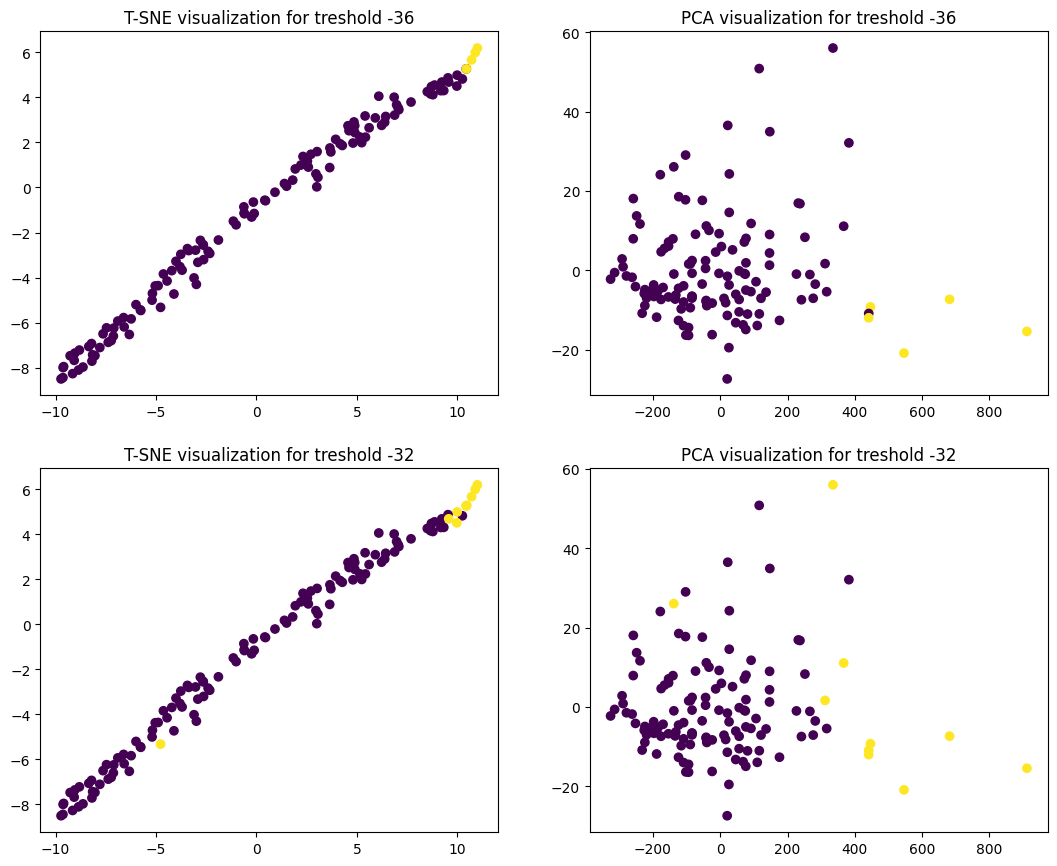

In [32]:
valPlus = pd.concat([train_x, test_x, val])

pca = PCA(n_components=2).fit_transform(valPlus)
tsnedata = TSNE().fit_transform(valPlus)

def visualizeResult(treshold):
    pred_y = gmm.score_samples(valPlus) < treshold
    
    addToGrid()
    plt.scatter(tsnedata[:,0], tsnedata[:,1], c=pred_y)
    plt.title('T-SNE visualization for treshold '+str(treshold))
    
    addToGrid()
    plt.scatter(pca[:,0], pca[:,1], c=pred_y)
    plt.title('PCA visualization for treshold '+str(treshold))

initPlotGrid(2, 4, True)
visualizeResult(-36)
visualizeResult(-32)
finalizePlotGrid()

Te wizualizacje są dużo bardziej dla nas przydatne. Zarówno w PCA jak i T-SNE widać że model z granicą `-32` błędnie klasyfikuje niektóre elementy jako outliery. Z drugiej strony, wizualizacje sugerują że model z granicą `-36` klasyfikuje nie wystarczająco punktów jako outliery. Dochodzi zatem znowu do tego samego wniosku - to, który model jest lepszy będzie zależał od skutków FP i FN.